# Identifying Common Academic Interests

- Peer groups in colleges prefer to choose common courses. 
- Moreover, we can segregate clusters of people with common academic intersts if we can somehow smartly organize the course data.
- The extensivity of the constructed graphs makes this task challenging.
- We will discuss multiple approaches of dealing with this big data.

In [1]:
# Necessary library Imports

import re
import urllib.request
import openpyxl
import requests
import pandas as pd
import os.path
import networkx as nx
import matplotlib.pyplot as plt
import random
from networkx.algorithms.community.centrality import girvan_newman

## Section 1: Web Scraper

- We will use the official course and student details of IIIT Jabalpur
- We have designed a web scraper to crawl through the web pages and scrap the required information
- We will sanitize this data and organize this into a Pandas dataframe

In [2]:
# Function definitions for web crawler

main_url = "https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/"

def parseForDownloadUrls():
    links = []
    resp = requests.get(main_url)
    page_str = str(resp.content)

    for word in page_str.split():
        # print(word)
        s = str(word)
        pattern = 'href=".*xlsx'
        mat = re.search(pattern, s)
        if mat:
            links.append(main_url+mat.group().split('"')[1])
    return links

def downloadUrls(link):

    out_filename = link.split('/')[-1].split('.')[0].replace("%20", " ")+'.csv'
    if os.path.isfile(out_filename):
        print('file exsists', out_filename)
    else:
        df = pd.read_excel(link)
        df.drop(df.index[:8], inplace=True)
        df = df.iloc[:,1:5]
        df = df.reset_index(drop = True)
        df.index += 1
        df.to_csv(out_filename)
        print('downloaded', out_filename)
    return out_filename

In [3]:
# Driver Code for Scrapping using Web crawler

download_urls = parseForDownloadUrls()
print("These are the obtained links:-")
for i in range(len(download_urls)):
    print(i+1,"-",download_urls[i])

downloaded_files = []

for url in download_urls:
    try:
        filename = downloadUrls(url)
        downloaded_files.append(filename)

    except:
        print('cannot download', url)
        
# Download if files do not exist 

ConnectionError: HTTPSConnectionPool(host='www.iiitdmj.ac.in', port=443): Max retries exceeded with url: /admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001DF88770D60>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

In [4]:
print("No. of Courses")
print(len(downloaded_files))

131


## Section 2: Organizing the data


- The downloaded data organized in the dataframe is stores in the dictionary format to support easy processing.
- The dictionaru student_data contains: student_data = {'roll': {'name':, 'branch':, 'courses': [], 'email': }}

In [5]:
student_data = {}
for filename in downloaded_files:
    try:
        df = pd.read_csv(filename)
    except:
        print('cannt open file', filename)
    course_name = filename.split('.')[0]
    for ind in df.index:
        roll = str(df['Unnamed: 1'][ind]).strip()
        if roll in student_data:
            student_data[roll]['courses'].append(course_name)
        else:
            student_data[roll] = {'name': str(df['Unnamed: 2'][ind]), 'branch': str(df['Unnamed: 3'][ind]), 'courses': [course_name]}


In [6]:
# Each entry respresnt a student
print(len(student_data))

1498


## Section 3: Constructing the Graph

In [23]:
G = nx.Graph()
for k in list(student_data.keys()):
    G.add_node(str(k))

edges = {}

for n1 in G.nodes():
    for n2 in G.nodes():
        if n1 >= n2:
            continue
        for course in student_data[n1]['courses']:
            if course in student_data[n2]['courses']:
                if (n1, n2) in edges:
                    edges[(n1, n2)] += 1
                else:
                    edges[(n1, n2)] = 1
for e in edges.keys():
    G.add_edge(e[0], e[1], weight = edges[e])
print(len(edges))

769420


In [9]:
# Key of d represents number of common courses between 2 students, and value indicates number of edges with that weight.
 
d = {}
for x in edges.keys():
    if edges[x] in d:
        d[edges[x]] += 1
    else:
        d[edges[x]] = 1
print(d)

{9: 21035, 10: 7861, 8: 39808, 7: 14693, 3: 115839, 2: 51666, 4: 74570, 1: 429400, 6: 2230, 5: 11961, 11: 357}


([<matplotlib.axis.XTick at 0x2b03b1d4a60>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11')])

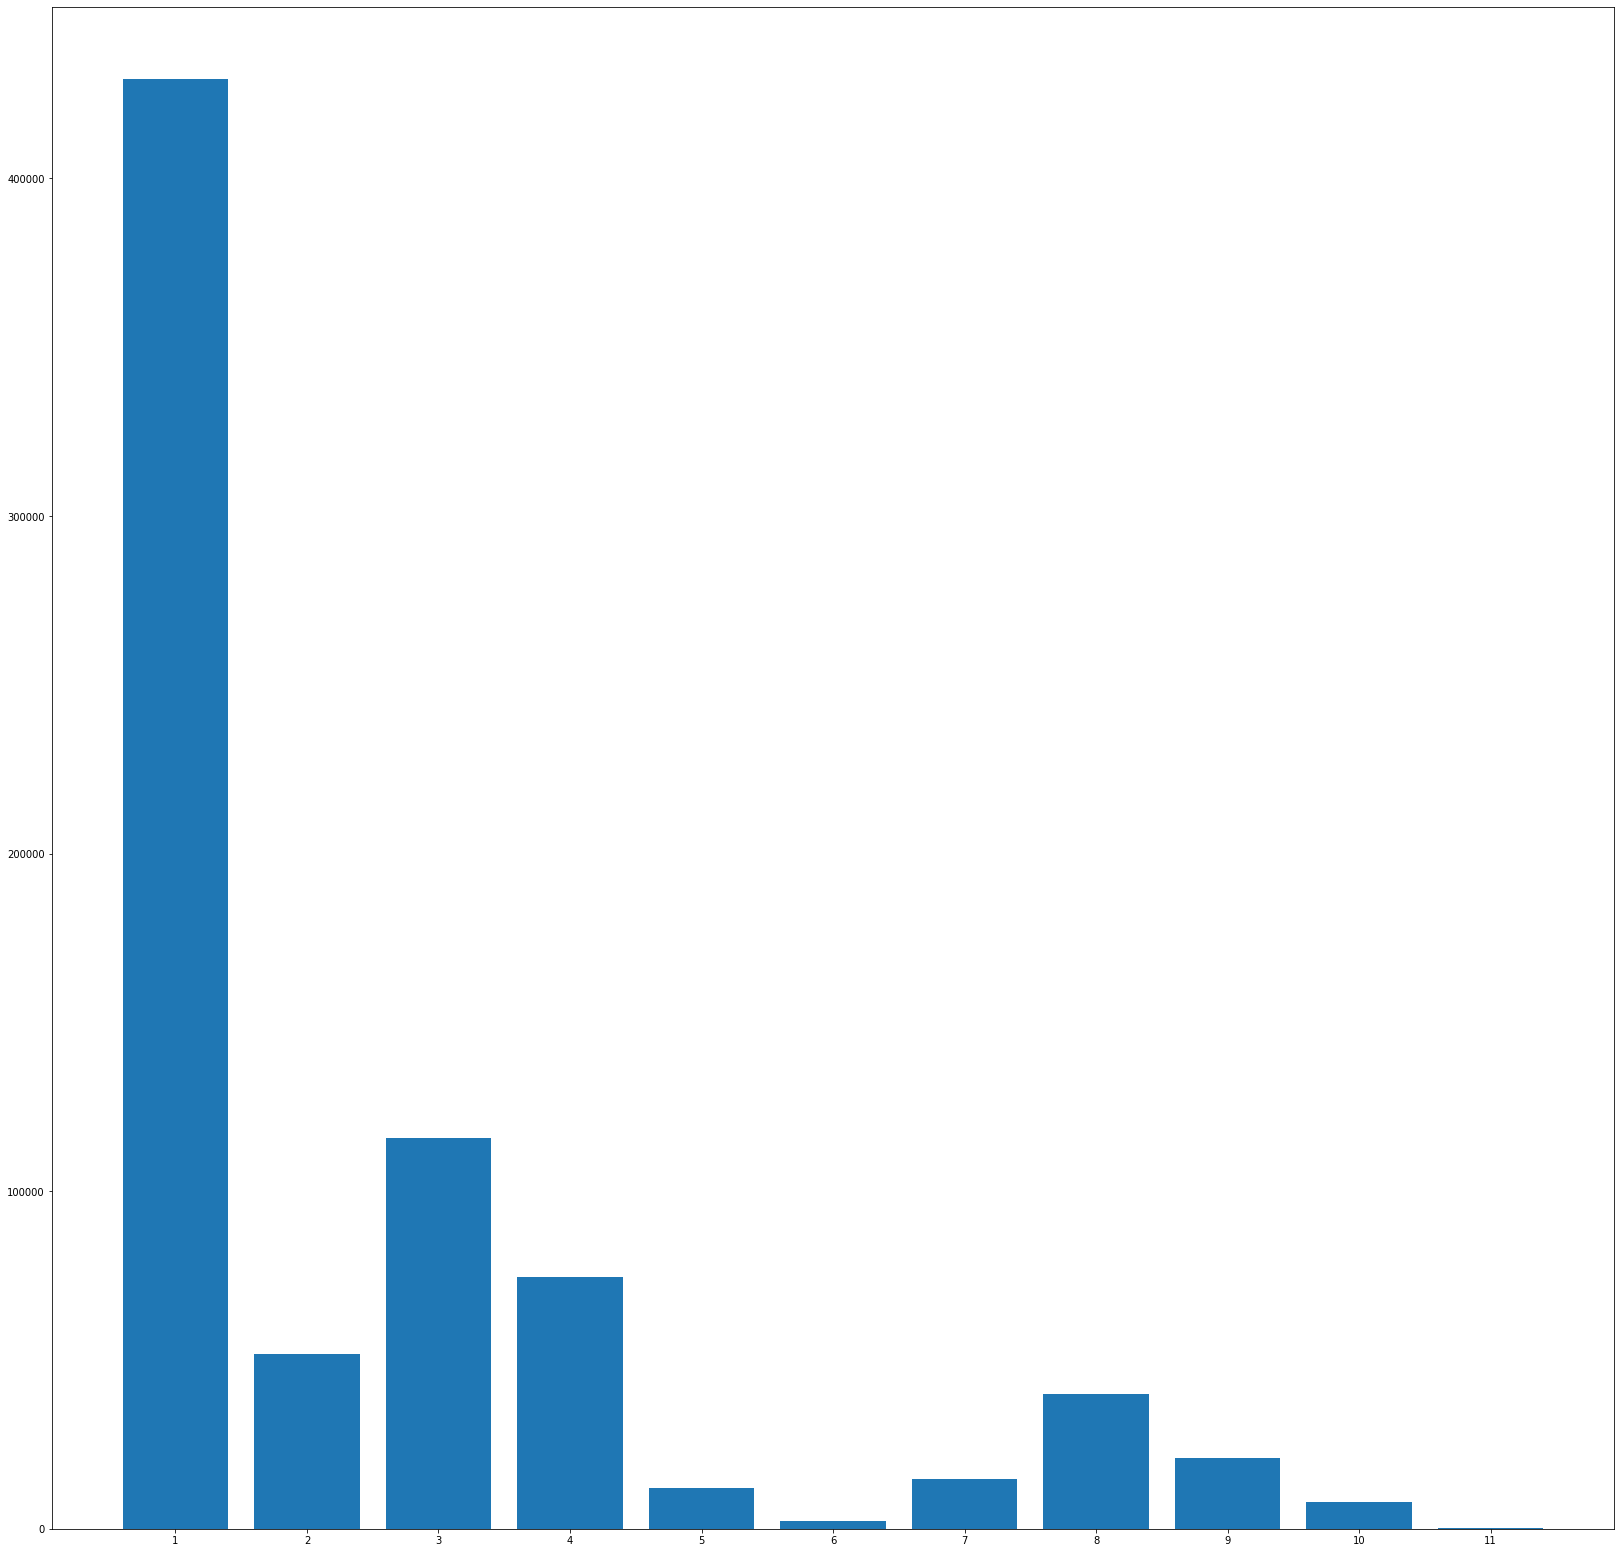

In [22]:
k = list(d.keys())
k.sort()
v = [d[x] for x in k]
plt.bar(range(len(d)), v, align='center')
plt.xticks(range(len(d)), k)

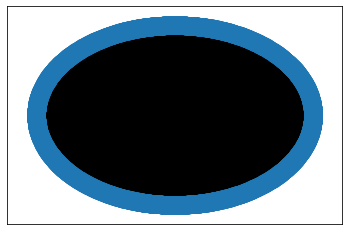

In [10]:
# Plotting entire figure

plt.rcParams['figure.figsize'] = [28,28]
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, with_labels=False)
plt.show()

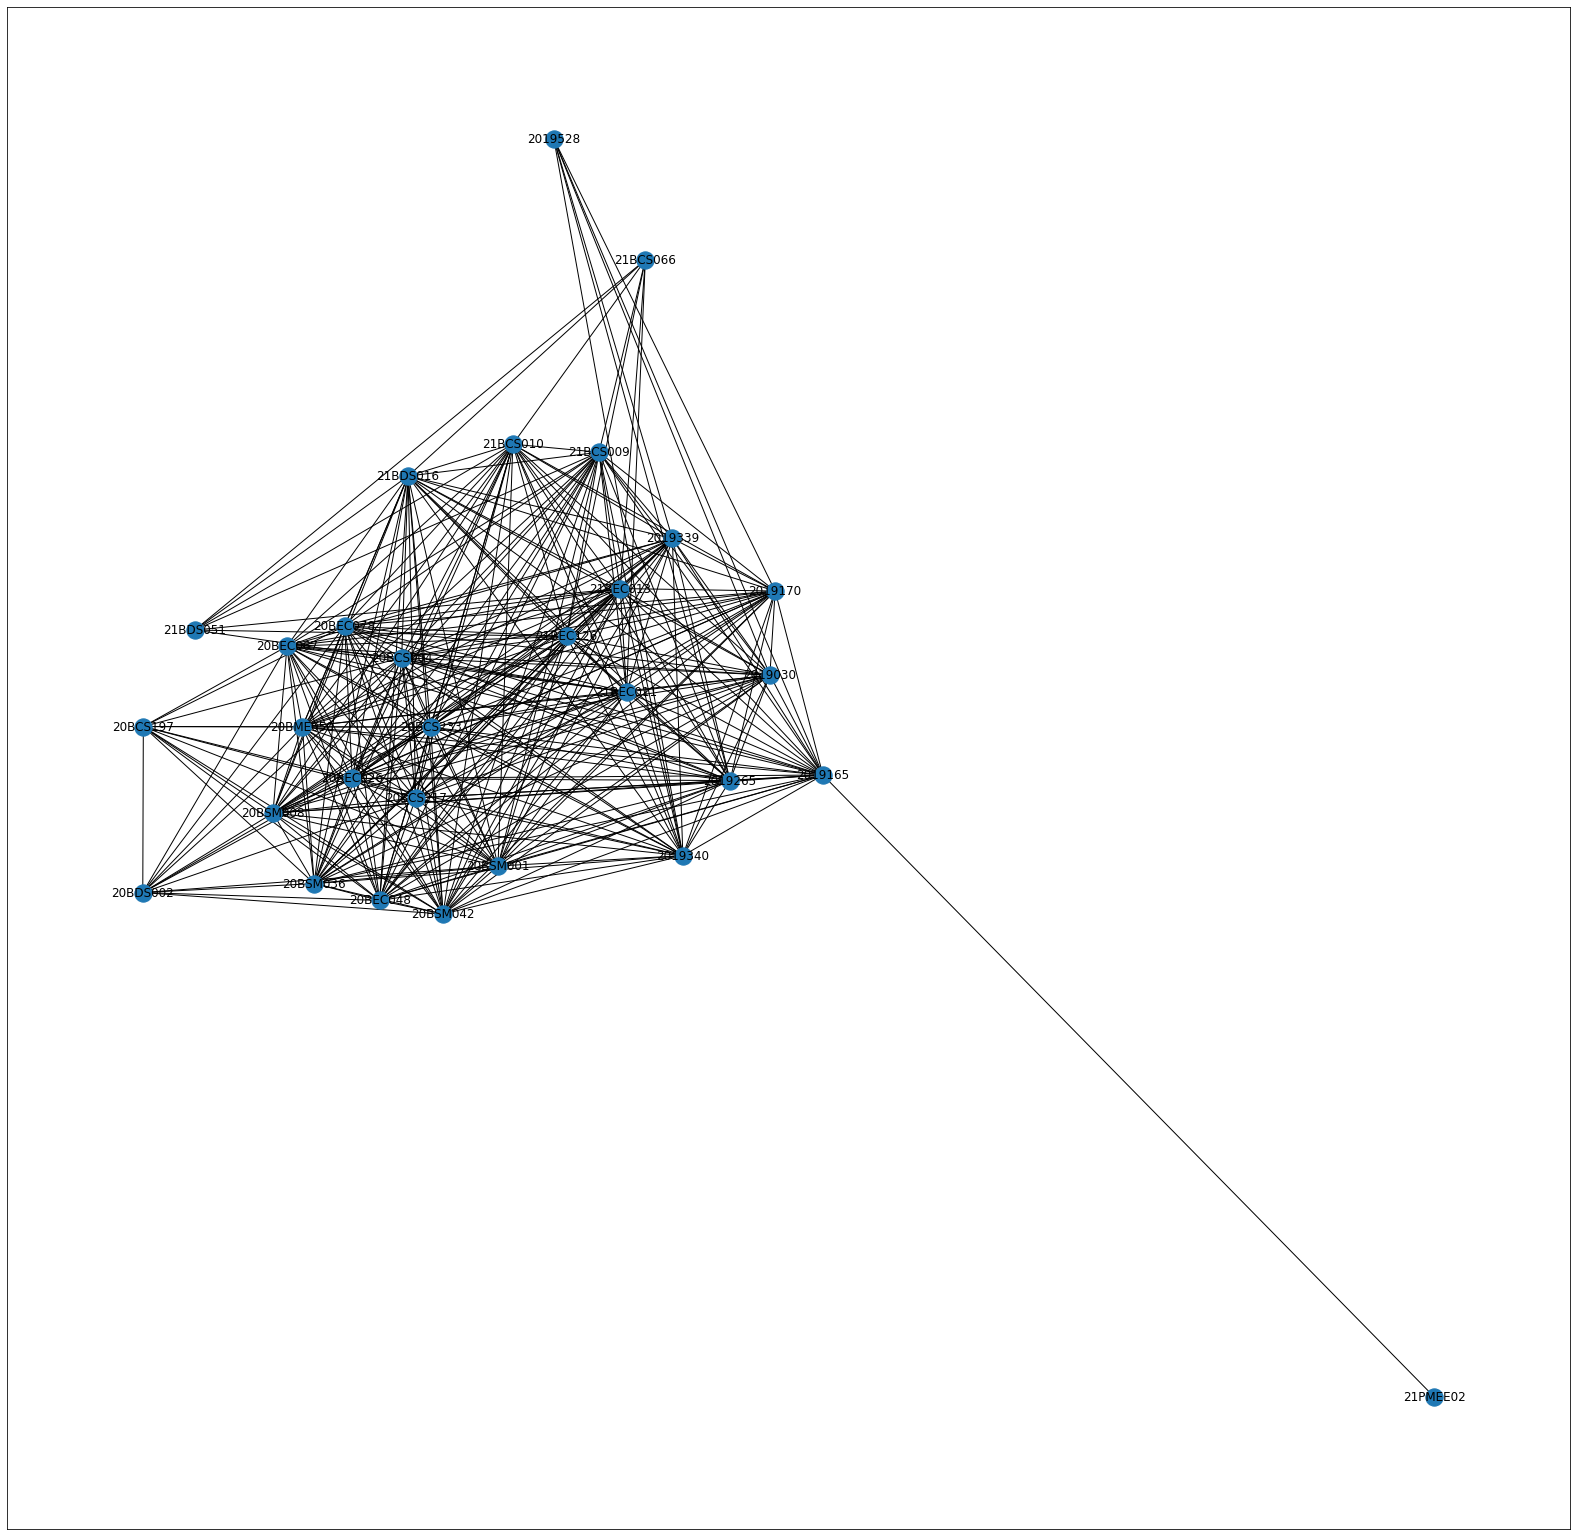

In [19]:
slg = list(G.nodes())
random.shuffle(slg)
Gs = G.subgraph(slg[:30])

plt.rcParams['figure.figsize'] = [28,28]
pos = nx.spring_layout(Gs, k=0.5, iterations=20)
nx.draw_networkx(Gs, pos, with_labels=True)
plt.show()

In [12]:
print(student_data['2018298'])

{'name': 'YUGANT VERMA', 'branch': 'CSE', 'courses': ['DS3001-Engineering Design  Including Design and Fabrication Project', 'EC8017-Internet of Things', 'IT3C01-Computer Network Lab', 'OE4L01-Japanese Course -UG2019', 'OE4L01-Japanese Course', 'OE4L73-Life Skills Management', 'OE4M23-Business Analytics using R']}


In [14]:
sgl = list(G.nodes())
random.shuffle(sgl)
Gs = G.subgraph(sgl[:200])
communities = girvan_newman(Gs)
node_groups = []
for com in next(communities):
    node_groups.append(list(com))
print(node_groups)

[['20BCS042', '20BCS121', '21BEC111', '21BSM021', '21BME033', '2019169', '2019366', '2019002', '20BDS024', '2019046', '20BDS062', '20BEC025', '21BCS198', '20BEC043', '21BCS051', '21BCS085', '21BDS051', '20BEC072', '20BCS209', '20BEC120', '21BCS058', '21BCS151', '20BCS012', '21BCS081', '20BDS053', '2019183', '21BCS247', '2019302', '2019086', '20BCS227', '2019174', '2019190', '21BCS220', '21BEC025', '21BSM031', '20BME033', '20BEC115', '21BEC008', '21BSM008', '20BEC009', '21BEC038', '20BDS065', '2019224', '2019181', '21BEC058', '20BCS068', '20BSM004', '21BCS090', '20BME009', '21BCS131', '20BME053', '2019145', '21BCS020', '2019311', '2019095', '21BCS181', '20BCS181', '21BEC085', '21PMEE02', '20BDS022', '21BSM038', '2019275', '21PECE07', '20BDS045', '21BDS010', '20BEC036', '20BSM050', '20BEC055', '20BEC044', '2019134', '20BCS183', '21BCS028', '20BCS016', '20BEC091', '2019280', '20BDS039', '22PCSO02', '20BCS041', '21BSM014', '21BEC032', '20BSM063', '21BEC019', '20BCS130', '21BEC034', '21BEC0

- We can notice the identified communities are not very well justified
- Not much information can be gained

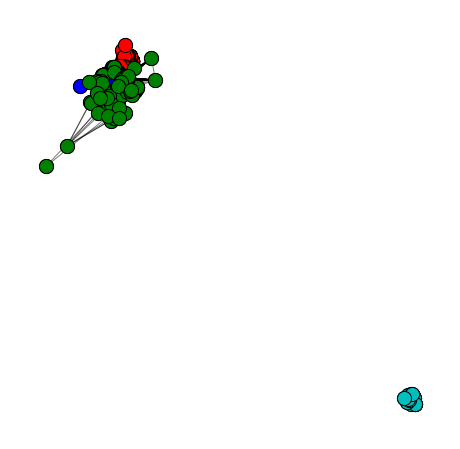

In [17]:
# This cell will take 10 mins to Run to identify top 4 communities due to high number of edges
from cdlib import algorithms, viz
coms = algorithms.leiden(G)

viz.plot_network_clusters(G, coms, pos, top_k=4)